# suffix tree

In [276]:
from graphviz import Source

In [277]:
# each bracketed slice mark represents a part of a text like array indexing
# [a/b] represents a part of text that starts at character of index a(inclusively) and ends at b(exclusively)


class SuffixNode:
    counter = 0

    def __init__(self, text, start=0, end=0, depth=0, parent=None):
        # reference to the text(for accesing it with indexing)
        self.text = text

        # starting and ending index of text represented by the edge between parent and node
        self.start = start
        self.end = end

        # self explainatory
        self.parent = parent
        self.depth = depth
        self.children = {}

        # for finding a stubstring in text
        self.leaf_index = None

        # for visualisation
        self.id = SuffixNode.counter
        SuffixNode.counter += 1

    # adding a piece of a text to a node - creating a new edge in a tree
    # new start - index of the first letter of newly grafted suffix
    def graft(self, new_start):

        # initially we set each ending of a grafted branch as the end of the text. It's always a suffix so we can do that
        new_end = len(self.text)

        # we calculate new depth of the child
        new_depth = self.depth + (new_end - new_start)

        # we create the new child
        child = SuffixNode(self.text, new_start, new_end, new_depth, self)
        self.children[self.text[new_start]] = child

        # note that the newly created child is a leaf node
        return child

    # break-path function breaks an edge of the tree and creates a new node at the breaking point
    # we insert a new node between the current node and one of its children
    def break_path(self, string):
        length = len(string)
        child = self.children[string[0]]

        # we create the new node(note that the information about an edge is stored in the child)
        new_node = SuffixNode(
            self.text, child.start, child.start + length, self.depth + length, self
        )
        child.start = child.start + length
        child.parent = new_node
        new_node.children[self.text[child.start]] = child
        self.children.pop(string[0])
        self.children[string[0]] = new_node

        # we have to return the node for further grafting operation
        return new_node

    # slow-find function's purpose is to find or create a new node,
    # that will start a new branch in a tree, for a given string
    def slow_find(self, string):

        # it's a recursive function so it needs a stop condition
        # we stop if the string ends or if the node doesn't have the proper child
        if len(string) == 0 or string[0] not in self.children.keys():
            return self

        # we get the next node from our path. We'll either travel through the whole length of the string...
        child = self.children[string[0]]
        for i in range(1, child.end - child.start):
            # ... or stop at the point where we find a mismatch
            if self.text[child.start + i] != string[i]:
                # in this case we'll have to break the path(create a new node between the processed parent and child)
                # it will be the returned node
                return self.break_path(string[:i])

        # if we manage to reach the end of slow-find's for loop we have to continue the recursion
        return child.slow_find(string[child.end - child.start :])

    # functions for visualisation
    def dot_node(self):
        return f'{self.id} [label="", shape="point"];'

    def dot_edges(self):
        result = []
        for child in self.children.values():
            if child.start + 1 == child.end:
                newLabel = child.text[child.start]
            else:
                newLabel = f"[{child.start}/{child.end}]"
            result.append(
                f'{self.id} -> {child.id}[arrowhead="none", label=" {newLabel}"];'
            )
        return "\n".join(result)

    def get_all_children(self):
        result = [self]
        for child in self.children.values():
            result += child.get_all_children()
        return result

    def show_tree(self):
        nodes = self.get_all_children()
        SuffixNode.show_graph(nodes)

    @staticmethod
    def show_graph(nodes):
        result = "digraph{\n"
        ranks = {}
        for node in nodes:
            result += node.dot_node() + "\n"
            result += node.dot_edges() + "\n"
            if node.depth not in ranks:
                ranks[node.depth] = []
            ranks[node.depth].append(node.id)
        for key, values in ranks.items():
            values = " ".join([f"{v};" for v in values])
            result += " { rank=same; " + values + "}\n"
        result += "\n}"
        s = Source(result)
        display(s)

In [278]:
class SuffixTree:
    def __init__(self, text):

        # we initialize the root node
        self.root = SuffixNode(text)
        leaf = self.root.graft(0)
        leaf.leaf_index = 0

        # and for each suffix in the text
        for i in range(1, len(text)):

            # we find and/or break the edge at which the path defined by the suffix ends in the existing tree
            head = self.root.slow_find(text[i:])

            # then we add a new node there
            leaf = head.graft(i + head.depth)

            # and we index the leaf to allow us to look up strigns easily
            leaf.leaf_index = i

    # this function, for certain pattern, returns indexes at which that pattern starts
    def find_string(self, pattern):
        result = []

        # the depth-first search recursive function that finds every leaf in a subtree and adds it to the resulting set
        def dfs(node):
            for child in node.children.values():
                dfs(child)

            if not node.children:
                result.append(node.leaf_index)

        # we'll descend the tree following the letters in the pattern
        node = self.root
        curr_start_idx = 0

        while True:
            # we end our loop if there's no matching letter in the children nodes
            if pattern[curr_start_idx] not in node.children.keys():
                return result

            child = node.children[pattern[curr_start_idx]]

            # we can only go to the child if our pattern is longer than the edge length
            if len(pattern[curr_start_idx:]) > child.end - child.start:

                # if the next part of the pattern doesn't match the text represented by the edge,
                # we won't find any more matches
                if (
                    pattern[curr_start_idx : curr_start_idx + child.end - child.start]
                    != child.text[child.start : child.end]
                ):
                    return result

                # go to the next child
                curr_start_idx += child.end - child.start
                node = child
                continue

            # If the remaining pattern matches the text we can add all corresponding .
            if (
                pattern[curr_start_idx:]
                == child.text[child.start : child.start + len(pattern) - curr_start_idx]
            ):
                dfs(child)
                return result

        return result

    # visualisation
    def show_stree(self):
        self.root.show_tree()

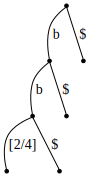

In [279]:
text0 = "bbb$"
tree0 = SuffixTree(text0)
tree0.show_stree()

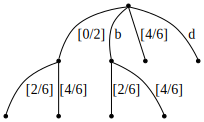

In [280]:
text1 = "ababcd"
tree1 = SuffixTree(text1)
tree1.show_stree()

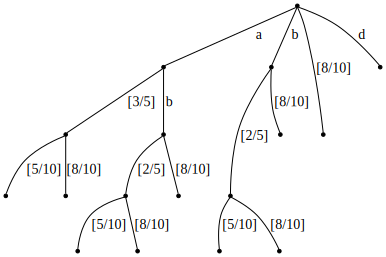

In [281]:
text2 = "abaabaabcd"
tree2 = SuffixTree(text2)
tree2.show_stree()

In [282]:
tree2.find_string("ba")

[1, 4]

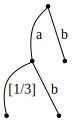

In [283]:
SuffixTree("aab").show_stree()